### Team : Group 5

### Group members
1. Pavithree Shetty - 220200661
2. Nisha Sharma - 220202359
3. Shweta mishra - 220201223
4. Pathey Pandeya - 219203197

# Visualising the petrinet from Alpha Plus miner - PROM

In [1]:
!pip install pm4py

C:\Users\Pavithre B Shetty\anaconda3\envs\tensorflow\lib\site-packages\pm4py\objects\petri\__init__.py:19: UserWarning: please use the pm4py.objects.petri_net package instead.
  warnings.warn('please use the pm4py.objects.petri_net package instead.')
C:\Users\Pavithre B Shetty\anaconda3\envs\tensorflow\lib\site-packages\pm4py\objects\petri\obj.py:19: UserWarning: pm4py.objects.petri.obj is deprecated. Please use the class pm4py.objects.petri_net.obj instead.
  warnings.warn("pm4py.objects.petri.obj is deprecated. Please use the class pm4py.objects.petri_net.obj instead.")
C:\Users\Pavithre B Shetty\anaconda3\envs\tensorflow\lib\site-packages\pm4py\objects\petri\exporter\__init__.py:21: UserWarning: please use the pm4py.objects.petri_net.exporter package instead.
  warnings.warn('please use the pm4py.objects.petri_net.exporter package instead.')
C:\Users\Pavithre B Shetty\anaconda3\envs\tensorflow\lib\site-packages\pm4py\objects\petri\importer\__init__.py:21: UserWarning: please use the

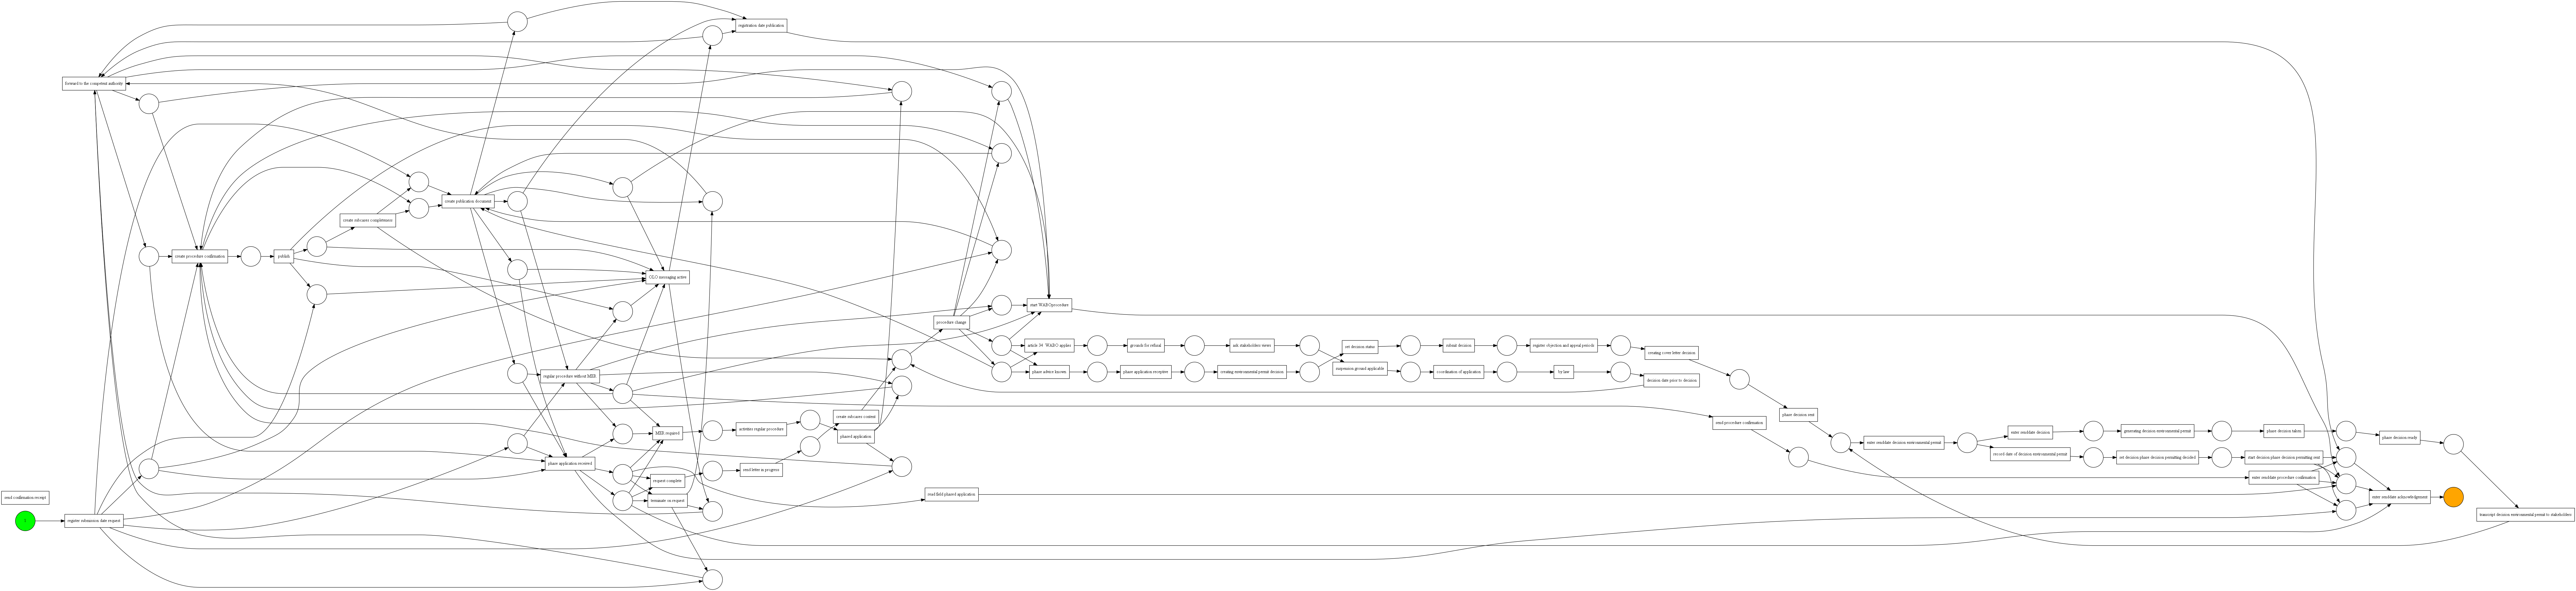

In [1]:
import os
import pm4py
import pandas as pd
from pm4py.objects.petri.importer import importer as pnml_importer
from pm4py.visualization.petrinet import visualizer as pn_visualizer
from pm4py.objects.log.importer.xes import importer as xes_importer


#importing pnml model
activity_process_model, activity_initial_marking, activity_final_marking = pnml_importer.apply("alphaPlusProcessModel.pnml")

# Visualising pnml model
graphviz = pn_visualizer.apply(activity_process_model, activity_initial_marking, activity_final_marking)
pn_visualizer.view(graphviz)


## Importing log file

In [2]:
#Give path to the log file here
ModelLog = xes_importer.apply('BPIC15_1_updated.xes')

parsing log, completed traces ::   0%|          | 0/23 [00:00<?, ?it/s]

## Creating dataframe from log file


In [3]:
log_df = pd.DataFrame (columns = ['process_index','event_index' ,'event_name'])

for case_index,case in enumerate(ModelLog):
    for event_index, event in enumerate(case):
        log_df = log_df.append(pd.DataFrame({'process_id': case_index, 'event_id': event_index, 'event_name': event["activityNameEN"]}, index=[0]), ignore_index=True)

In [4]:
df_case = log_df.groupby(['process_id'])['event_name'].apply(list).reset_index()

In [5]:
#function to check if input transition is the sublist of the case
def sublist(lst1, lst2):
   list1 = [element for element in lst1 if element in lst2]
   list2 = [element for element in lst2 if element in lst1]
#    print(list1)
#    print(list2)
   if list1 == list2:
        if len(list1) > 0:
            return True
        else:
            return False
        

In [6]:
#function to calculate the probabilities
def updateDict(inDict):
    sum_denominator = list(inDict.values())
    total = 0
    for i in sum_denominator:
        total = total + i

    for task, occurance in inDict.items():
        inDict[task] = occurance/total
    return inDict

### Get n-grams

In [10]:
# input_transitions = ['register submission date request','create publication document']
input_transitions = ['request complete','send letter in progress','create subcases content']
input_transitions = input_transitions[::-1]

#get the n-gram lists
numElems = len(input_transitions)
outlist = [[] for i in range(numElems)]
for i in range(0,numElems):
    if i == 0:
        outlist[i].append(input_transitions[i])
    else:     
        outlist[i].append(input_transitions[i])
        outlist[i].extend(outlist[i-1])

print(outlist)        

[['create subcases content'], ['send letter in progress', 'create subcases content'], ['request complete', 'send letter in progress', 'create subcases content']]


### Calculate probabilities for predictions

In [11]:
length_n_grams = []
dict_dictionaries = []
next_transition_list = []
cases = list(df_case['event_name'])
filtered_ngram_cases = []

#loops through all the cases and calculates the probability of each predicted event
for n_gram in outlist:
    length_n_grams.append(len(n_gram))
    current_task = n_gram[-1]
    filtered_ngram_cases = []
    dict_probabilities = {}
    for case in cases:
        if sublist(n_gram,case) == True:
            filtered_ngram_cases.append(case)
            if current_task in case:
                current_task = n_gram[-1]
                current_task_index = case.index(current_task)
                next_transition_list.append(case[current_task_index+1])
    next_transition_list = list(set(next_transition_list))
    
    dict_probabilities = dict.fromkeys(next_transition_list,0)
    
    for subcase in filtered_ngram_cases:
        for task in next_transition_list:
            if current_task in subcase:
                current_task_index = subcase.index(current_task)
                next_task = current_task_index +1
                if task == subcase[next_task]:
                    dict_probabilities[task] = dict_probabilities[task] + 1
                
    dict_dictionaries.append(dict_probabilities)

            
#calculate the overall probability            
for item in dict_dictionaries:
    item = updateDict(item)

#create a dataframe from the obtained results
column_names = ['n_gram','Predicted_Event','Probabilities']

df = pd.DataFrame(columns = column_names)

n_gram_idx = 0
for ele in dict_dictionaries:
    dfTmp = pd.DataFrame(columns = column_names)
    dfTmp['Predicted_Event'] = ele.keys()
    dfTmp['Probabilities'] = ele.values()
    length = len(ele)
    dfTmp['n_gram'][0:length] = length_n_grams[n_gram_idx]
    n_gram_idx = n_gram_idx + 1
    df = df.append(dfTmp, ignore_index=True)
    

df

C:\Users\Pavithre B Shetty\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,n_gram,Predicted_Event,Probabilities
0,1,procedure change,1.0
1,2,procedure change,1.0
2,3,procedure change,1.0
